# Multidimensional Calibration Comparison

Goal: To compare two calibrations (corrections) at different points in impedance space

Method:
1. Create a set of "synthetic" standards in the DUT reference plane. These standards should have the following properties:
        + Occupy many points in impedance space
        + Be constant as a function of frequency
        + Be spaced further apart than the mean error
2. Use the reference (calibration with lowest uncertainty) to move the points to the measurement plane. This can be thought of uncorrecting the data
3. Use the comparison calibration to move the points from the measurement plane to the reference plane
4. Color code the points based on their distance from the original points 


In [1]:
from pyMez import *
from pyMez.Code.Analysis.SParameter import *

Importing pyMez, this should take roughly 30 seconds
Importing Code.DataHandlers.GeneralModels
It took 3.557 s to import Code.DataHandlers.GeneralModels
Importing Code.DataHandlers.HTMLModels
It took 0.499 s to import Code.DataHandlers.HTMLModels
Importing Code.DataHandlers.NISTModels
It took 8.442 s to import Code.DataHandlers.NISTModels
Importing Code.DataHandlers.TouchstoneModels
It took 0.007 s to import Code.DataHandlers.TouchstoneModels
Importing Code.DataHandlers.XMLModels
It took 0.266 s to import Code.DataHandlers.XMLModels
Importing Code.DataHandlers.ZipModels
It took 0.02 s to import Code.DataHandlers.ZipModels
Importing Code.InstrumentControl.Experiments
It took 1.159 s to import Code.InstrumentControl.Experiments
Importing Code.InstrumentControl.Instruments
It took 0.012 s to import Code.InstrumentControl.Instruments
Importing Code.Utils.Names
It took 0.008 s to import Code.Utils.Names
It took 13.97 s to import all of the active modules


In [6]:
def create_synthetic_standards_DUT_plane(frequency_list,r1=.98,r2=.2,r3=.6,**options):
    """Creates a set of points in the DUT reference plane, outputs a list of S2PV1 objects"""
    defaults={}
    standard_options={}
    for key,value in defaults.iteritems():
        standard_options[key]=value
    for key,value in options.iteritems():
        standard_options[key]=value
    output_list=[]
    s11_points=[]
    s21_points=[]
    for i in range(8):
        s11_points.append(cmath.rect(r1,cmath.pi*(i)/4))
    for i in range(4):
        s11_points.append(cmath.rect(r2,cmath.pi*(i)/2+cmath.pi/4))
    for i in range(8):
        s11_points.append(cmath.rect(r3,cmath.pi*(i)/4+cmath.pi/8))
    for i in range(8):
        s21_points.append(cmath.rect(np.sqrt(1-r1**2),cmath.pi*(i)/4))
    for i in range(4):
        s21_points.append(cmath.rect(np.sqrt(1-r2**2),cmath.pi*(i)/2+cmath.pi/4))
    for i in range(8):
        s21_points.append(cmath.rect(np.sqrt(1-r3**2),cmath.pi*(i)/4+cmath.pi/8))
    for index,point in enumerate(s11_points):
        data_list=[]
        for f in frequency_list:
            data_list.append([f,point,s21_points[index],s21_points[index],point])
        output_list.append(S2PV1(sparameter_complex=data_list,option_line='# GHz S RI R 50'))
    return output_list
            
def create_synthetic_standards_measurement_plane(r1=.98,r2=.2,r3=.6,s4p=None,**options):
    """Creates a set of points in the DUT reference plane, outputs a list of S2PV1 objects"""
    defaults={}
    standard_options={}
    for key,value in defaults.iteritems():
        standard_options[key]=value
    for key,value in options.iteritems():
        standard_options[key]=value
    frequency_list=s4p["Frequency"]
    output_list=[]
    s11_points=[]
    s21_points=[]
    for i in range(8):
        s11_points.append(cmath.rect(r1,cmath.pi*(i)/4))
    for i in range(4):
        s11_points.append(cmath.rect(r2,cmath.pi*(i)/2+cmath.pi/4))
    for i in range(8):
        s11_points.append(cmath.rect(r3,cmath.pi*(i)/4+cmath.pi/8))
    for i in range(8):
        s21_points.append(cmath.rect(np.sqrt(1-r1**2),cmath.pi*(i)/4))
    for i in range(4):
        s21_points.append(cmath.rect(np.sqrt(1-r2**2),cmath.pi*(i)/2+cmath.pi/4))
    for i in range(8):
        s21_points.append(cmath.rect(np.sqrt(1-r3**2),cmath.pi*(i)/4+cmath.pi/8))
    for index,point in enumerate(s11_points):
        data_list=[]
        for f in frequency_list:
            data_list.append([f,point,s21_points[index],s21_points[index],point])
        measurement_data_list=uncorrect_sparameters_sixteen_term(sparameters_complex=data_list,
                                           sixteen_term_correction=s4p.sparameter_complex)
        output_list.append(S2PV1(sparameter_complex=measurement_data_list,option_line='# GHz S RI R 50'))
    return output_list

def correct_all_sixteen_term(s2p_list,correction):
    """Corrects all s2ps in list and returns a new list of corrected DUTs"""
    output_list=[]
    for s2p in s2p_list:
        corrected_s2p=correct_sparameters_sixteen_term(sparameters_complex=s2p.sparameter_complex,
                                                       sixteen_term_correction=correction.sparameter_complex)
        output_list.append(S2PV1(sparameter_complex=corrected_s2p))
    return output_list

def two_port_complex_plot(s2p_list,**options):
    fig,axes=plt.subplots(nrows=2, ncols=2, figsize=(7,7),dpi=80)
    plot_names=["S11","S21","S12","S22"]
    for s2p in s2p_list:
        for index,ax in enumerate(axes.flat):
            ax.plot(s2p["re{0}".format(plot_names[index])],
                    s2p["im{0}".format(plot_names[index])],'o',fillstyle='none',markersize=10);
            ax.set_ylim([-1.2,1.2]);
            ax.set_xlim([-1.2,1.2]);
            ax.set_title(plot_names[index]);
            ax.set_xlabel("Re({0})".format(plot_names[index]))
            ax.set_ylabel("Imag({0})".format(plot_names[index]))
    plt.tight_layout()
    plt.show()
    
def two_port_complex_plot_compare(s2p_list_1,s2p_list_2,**options):
    map(lambda x: x.change_data_format("RI"),s2p_list_1)
    map(lambda x: x.change_data_format("RI"),s2p_list_2)


    fig,axes=plt.subplots(nrows=2, ncols=2, figsize=(7,7),dpi=80)
    plot_names=["S11","S21","S12","S22"]

    for s2p in s2p_list_2:
        for index,ax in enumerate(axes.flat):
            ax.plot(s2p["re{0}".format(plot_names[index])],
                    s2p["im{0}".format(plot_names[index])],'bx');
            ax.set_ylim([-1.1,1.1]);
            ax.set_xlim([-1.1,1.1]);
            ax.set_title(plot_names[index]);
            #ax.set_xlabel("Re({0})".format(plot_names[index]))
            #ax.set_ylabel("Imag({0})".format(plot_names[index]))
    for s2p in s2p_list_1:
        for index,ax in enumerate(axes.flat):
            ax.plot(s2p["re{0}".format(plot_names[index])],
                    s2p["im{0}".format(plot_names[index])],'yo',fillstyle='none',markersize=10);
            ax.set_ylim([-1.1,1.1]);
            ax.set_xlim([-1.1,1.1]);
            ax.set_title(plot_names[index]);
    plt.tight_layout()
    plt.show()
def two_port_complex_plot_compare_animate(s2p_list_1,s2p_list_2,**options):
    map(lambda x: x.change_data_format("RI"),s2p_list_1)
    map(lambda x: x.change_data_format("RI"),s2p_list_2)


    fig,axes=plt.subplots(nrows=2, ncols=2, figsize=(7,7),dpi=80)
    plot_names=["S11","S21","S12","S22"]
    images=[]
    frequency_list=s2p_list_2[0]["Frequency"]
    for f_index,f in enumerate(frequency_list):
    
        for s2p in s2p_list_2:
            for index,ax in enumerate(axes.flat):
                ax.plot(s2p["re{0}".format(plot_names[index])][f_index],
                        s2p["im{0}".format(plot_names[index])][f_index],'bx');
                ax.set_ylim([-1.1,1.1]);
                ax.set_xlim([-1.1,1.1]);
                ax.set_title(plot_names[index]); 
        for s2p in s2p_list_1:
            for index,ax in enumerate(axes.flat):
                ax.plot(s2p["re{0}".format(plot_names[index])][f_index],
                        s2p["im{0}".format(plot_names[index])][f_index],'yo',fillstyle='none',markersize=10);
                ax.set_ylim([-1.1,1.1]);
                ax.set_xlim([-1.1,1.1]);
                ax.set_title(plot_names[index]);
        fig.suptitle("f = {0}".format(f))
        
        plt.tight_layout()
        plt.savefig("C:\Share\Calibration_Comparison\TRLvsSeriesR4\Calibration_Compare_f_{0}.png".format(f))
        
def compare_calibrations_script(c1_path,c2_path):
    """"""
    c1=SNP(c1_path,number_ports=4)
    c2=SNP(c2_path,number_ports=4)
    r1=.98
    r2=.2
    r3=.6
    s2p_list=create_synthetic_standards_DUT_plane(c1["Frequency"],r1,r2,r3)
    measurement_plane_s2ps=create_synthetic_standards_measurement_plane(r1,r2,r3,c1)
    comparison_s2ps_dut_plane=correct_all_sixteen_term(measurement_plane_s2ps,c2)
    two_port_complex_plot_compare(s2p_list,comparison_s2ps_dut_plane)

In [4]:
plt.rcParams.update({'font.size': 16})

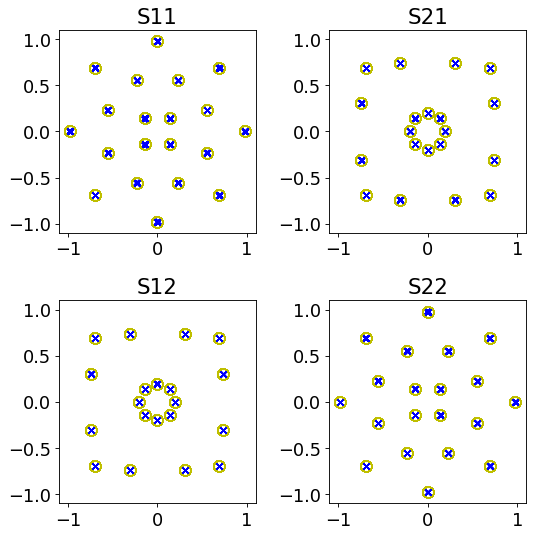

In [8]:
reference_calibration=r"C:\Share\WR15_OML_MUF_20180313\TRL_1\WR15_Menu_TrueThru_Switch_20180223_vnauncert_Results\Solutions\Solution_0.s4p"
comparison_calibration_1=r"C:\Share\WR15_OML_MUF_20180313\MTRL_1\WR15_Menu_TrueThru_Switch_20180223_vnauncert_Results\Solutions\Solution_0.s4p"
compare_calibrations_script(reference_calibration,comparison_calibration_1)

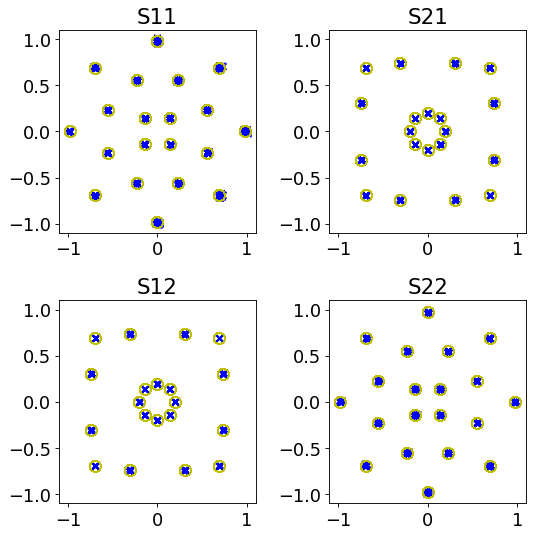

In [9]:
reference_calibration=r"C:\Share\WR15_OML_MUF_20180313\TRL_1\WR15_Menu_TrueThru_Switch_20180223_vnauncert_Results\Solutions\Solution_0.s4p"
comparison_calibration_1=r"C:\Share\WR15_OML_MUF_20180313\SOLT_1\WR15_SOLT_1_20180315_vnauncert_Results\Solutions\Solution_0.s4p"
compare_calibrations_script(reference_calibration,comparison_calibration_1)

In [16]:
class CalibrationComparison(object):
    """The CalibrationComparison class is meant to compare two calibrations by taking synthetic DUTs, complex constants as
    a function of frequency. Then uncalibrating using a reference calibration and recalibrating using a calibration 
    to compare.   """
    def __init__(self,c1_path,c2_path):
        """"""
        self.c1=SNP(c1_path,number_ports=4)
        self.c2=SNP(c2_path,number_ports=4)
        r1=.98
        r2=.2
        r3=.6
        self.s2p_list=create_synthetic_standards_DUT_plane(self.c1["Frequency"],r1,r2,r3)
        self.measurement_plane_s2ps=create_synthetic_standards_measurement_plane(r1,r2,r3,self.c1)
        self.comparison_s2ps_dut_plane=correct_all_sixteen_term(self.measurement_plane_s2ps,self.c2)
        self.synthetic_DUT_average_array=[]
        for s2p in self.s2p_list[:]:
            self.synthetic_DUT_average_array.append(np.mean(np.array(s2p.sparameter_complex[:]), axis = 0))

        self.comparison_s2ps_dut_plane_average_array=[]
     
        for s2p in self.comparison_s2ps_dut_plane[:]:
            self.comparison_s2ps_dut_plane_average_array.append(np.mean(np.array(s2p.sparameter_complex[:]), axis = 0))
        
    def show(self):
        two_port_complex_plot_compare(self.s2p_list,self.comparison_s2ps_dut_plane)
    def vector_plot(self):pass

In [17]:
new_compare=CalibrationComparison(reference_calibration,comparison_calibration_1)

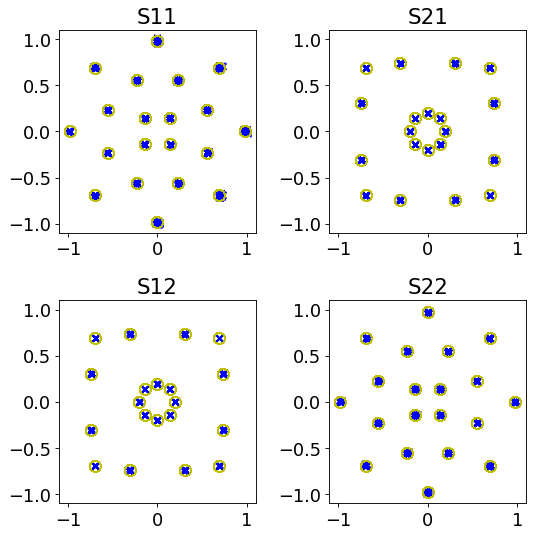

In [18]:
new_compare.show()

In [20]:
new_compare.synthetic_DUT_average_array[0]

array([ 62.50000000+0.j,   0.98000000+0.j,   0.19899749+0.j,
         0.19899749+0.j,   0.98000000+0.j])